<a href="https://colab.research.google.com/github/klouderm/DS6290_RMS/blob/main/Assignment5/assign_5_KylieLoudermilk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## License

Copyright 2021 Kylie Loudermilk (kylieloudermilk@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

# Assignment 5

#### Imports and inits

In [ ]:
!pip install h2o
!pip install interpret

In [ ]:
import h2o                                                        # h2o python library
from h2o.backend import H2OLocalServer                            # for model extraction
from h2o.estimators.random_forest import H2ORandomForestEstimator # for decision tree in model extraction
from interpret.perf import ROC                                    # ROC measure for xgb2
import matplotlib.pyplot as plt                                   # for plots
import numpy as np                                                # for basic array manipulation
import pandas as pd                                               # for dataframe manipulation
import subprocess                                                 # to run external processes for model extraction
import time                                                       # for timers

# enables display of images in notebook
from IPython.display import Image
from IPython.display import display

# set numpy random seed for better reproducibility
SEED = 12345
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='2G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators

#### Start global timer

In [3]:
tic = time.time()

In [ ]:
import io
from google.colab import files
from google.colab import drive
uploaded = files.upload() # upload training and test data
import pandas as pd
train = pd.read_csv(io.StringIO(uploaded['hmda_train_preprocessed.csv'].decode('utf-8')))
test = pd.read_csv(io.StringIO(uploaded['hmda_test_preprocessed.csv'].decode('utf-8')))
!pip install piml
from piml import Experiment
exp = Experiment()
#exp.data_loader(data=train)

In [5]:
drive.mount('/drive', force_remount=True)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Mounted at /drive


#### Import data

In [6]:
#data = pd.read_csv('../data/hmda_train_preprocessed.csv')
#test = pd.read_csv('../data/hmda_test_preprocessed.csv')
data=train

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

#### Assign basic modeling roles

In [7]:
y_name = 'high_priced'

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Fit interpretable model

#### Split data into train and validation partitions

In [8]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))


# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


###XGB2

#### Retrain most accurate model above 0.8 AIR to act as blackbox prediction API

In [9]:
from piml.models import XGB2Classifier

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [10]:
# params dict for remediated models
rem_params = {'n_estimators': 80,
              'max_bin': 20,
              'eta': 0.3,
              'gamma': 0.05,
              'random_state': 12345}

rem_x_names = ['intro_rate_period_std',
               'debt_to_income_ratio_missing',
               'conforming',
               'no_intro_rate_period_std',
               'income_std',
               'debt_to_income_ratio_std',
               'property_value_std',
               'term_360']

rem_xgb2 = XGB2Classifier(**rem_params)
rem_xgb2.fit(train[rem_x_names], train[y_name])
rem_xgb2_perf = ROC(rem_xgb2.predict_proba).explain_perf(valid[rem_x_names].to_numpy(), valid[y_name].to_numpy())
rem_auc = rem_xgb2_perf._internal_obj['overall']['auc']
print('Remediated XGB2 retrained with AUC: %.4f.' % rem_auc)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Remediated XGB2 retrained with AUC: 0.7795.


## Sensitivity Analysis: Stress Testing

#### Simulate recession conditions in validation data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

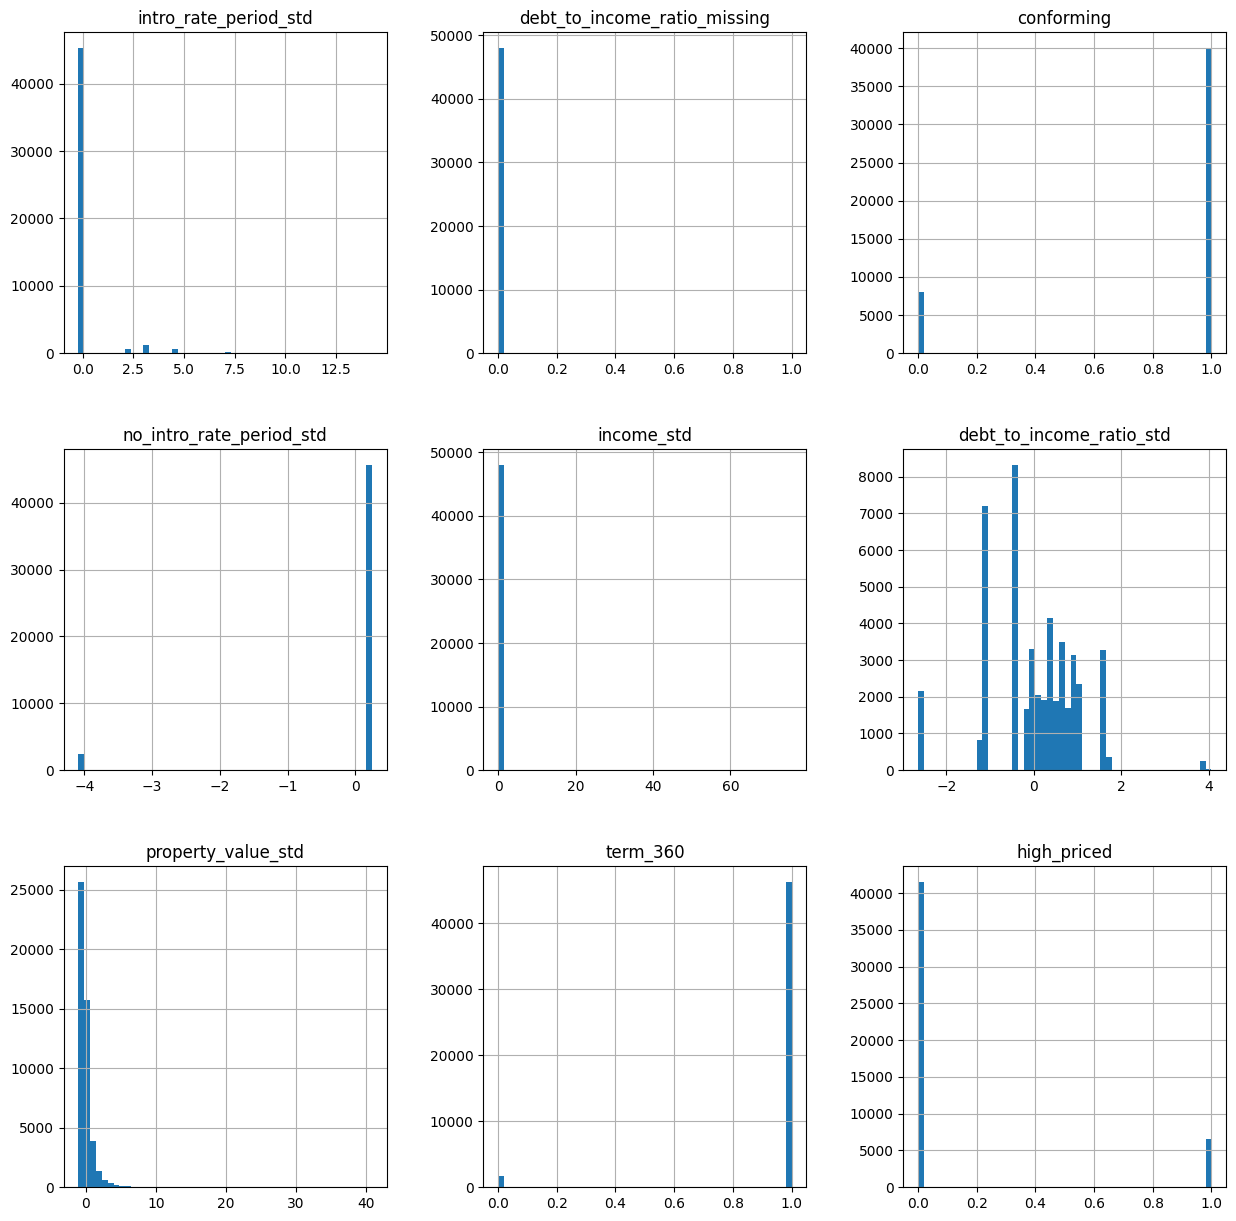

In [11]:
np.random.seed(SEED) # set seed for this cell

rec_valid = valid.copy(deep=True) # deep copy of validation data

# use severity variable to control how many customers are affected
severity = 0.1
affected = np.random.rand(len(rec_valid)) < severity

# decrease property values by 5%
rec_valid.loc[affected, 'property_value_std'] = rec_valid.loc[affected, 'property_value_std'] * 0.95

# less intro rates
rec_valid.loc[affected, 'no_intro_rate_period_std'] = 0.2443944

# lower loan amounts by 5%
rec_valid.loc[affected, 'loan_amount_std'] = rec_valid.loc[affected, 'loan_amount_std'] * 0.95

# lower income by 5%
rec_valid.loc[affected, 'income_std'] = rec_valid.loc[affected, 'income_std'] * 0.95

# less conforming loans
rec_valid.loc[affected, 'conforming'] = 0

# shorter intro rate periods
rec_valid.loc[affected, 'intro_rate_period_std'] = rec_valid.loc[affected, 'intro_rate_period_std'] * 0.95

# 5% higher debt-to-income ratios
rec_valid.loc[affected, 'debt_to_income_ratio_std'] = rec_valid.loc[affected, 'debt_to_income_ratio_std'] * 1.05

# more long loans
rec_valid.loc[affected, 'term_360'] = 1

# update target
rec_valid.loc[affected, y_name] = np.random.choice(2, len(rec_valid.loc[affected, y_name]))

# visualize results
_ = rec_valid[rem_x_names + [y_name]].hist(bins=50, figsize=(15, 15))

#### Find AUC for best model in simulated recession conditions

In [12]:
rec_rem_xgb2_perf = ROC(rem_xgb2.predict_proba).explain_perf(rec_valid[rem_x_names].to_numpy(), rec_valid[y_name].to_numpy())
rec_rem_auc = rec_rem_xgb2_perf._internal_obj['overall']['auc']
print('Remediated XGB2 retrained with AUC: %.4f.' % rec_rem_auc)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Remediated XGB2 retrained with AUC: 0.6742.


## Residual Analysis

#### Calculate predictions and logloss residuals for all data

In [13]:
# shortcut names
yhat_name = 'phat'
r_name = 'r'

# calculate predictions
rem_xgb2_phat = pd.DataFrame(rem_xgb2.predict_proba(data[rem_x_names])[:, 1], columns=['phat'])
rem_xgb2_phat = pd.concat([data.reset_index(drop=True), rem_xgb2_phat], axis=1)

# calculate logloss residuals
rem_xgb2_phat[r_name] = -rem_xgb2_phat[y_name]*np.log(rem_xgb2_phat[yhat_name]) -\
                       (1 - rem_xgb2_phat[y_name])*np.log(1 - rem_xgb2_phat[yhat_name])

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

#### Plot residuals

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

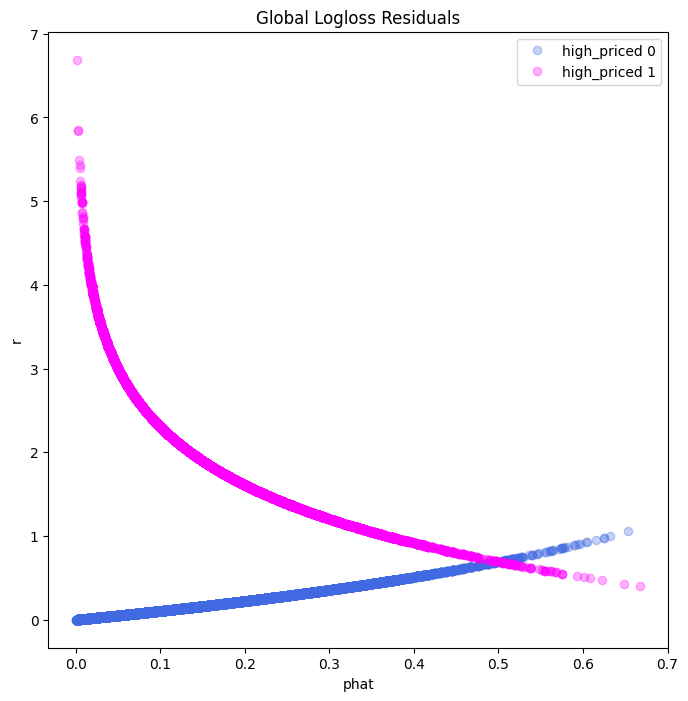

In [14]:
# initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))

# plot groups with appropriate color
color_list = ['royalblue', 'magenta']
c_idx = 0
groups = rem_xgb2_phat.groupby(y_name) # define groups for levels of PAY_0
for name, group in groups:
    ax_.plot(group.phat, group.r,
             label=' '.join([y_name, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1

# annotate plot
_ = plt.xlabel(yhat_name)
_ = plt.ylabel(r_name)
_ = ax_.legend(loc=1)
_ = plt.title('Global Logloss Residuals')

## Remediation: Remove Outliers

#### Find outliers

In [15]:
rem_xgb2_phat.sort_values(by='r', ascending=False).head()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat,r
110822,110822,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,0,1,0,0.892723,-0.874794,0.244394,-0.215304,1.252485,-0.007738,-1.156406,1,0.001245,6.688918
45113,45113,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0,1,0,-0.162614,-2.422899,0.244394,-0.215304,1.869180,-0.021597,0.397554,1,0.002875,5.851718
83113,83113,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,0,0,0,0.760806,-0.277030,0.244394,-0.215304,0.697459,0.017208,-0.059493,1,0.002901,5.842637
82041,82041,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,0,1,0,-0.954117,-2.973067,0.244394,-0.215304,0.697459,-0.052781,-0.425131,1,0.004132,5.488925
83269,83269,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,NaN,0,1,0,0.101220,-0.864984,0.244394,-0.215304,0.389111,-0.013282,0.031916,1,0.004375,5.431819


#### Remove worst outliers

In [16]:
n_remove = 10
rem_data = data.copy(deep=True)
rem_data.drop(list(rem_xgb2_phat.sort_values(by='r', ascending=False).head(n=n_remove).index), axis=0, inplace=True)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Remediation: Down-sample to Increase Signal from High-priced Loans

In [17]:
inverse_proportion_remove = 2 # corresponds to keeping 1 - (1/inverse_proportion_remove) rows
rem_data.drop(list(rem_data[rem_data[y_name] == 0].index)[::inverse_proportion_remove], axis=0, inplace=True)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

#### Retrain remediated EBM

In [18]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

# execute split
split = np.random.rand(len(rem_data)) < split_ratio
rem_train = rem_data[split]
rem_valid = rem_data[~split]

# summarize split
print('Remediated train data rows = %d, columns = %d' % (rem_train.shape[0], rem_train.shape[1]))
print('Remediated validation data rows = %d, columns = %d' % (rem_valid.shape[0], rem_valid.shape[1]))

# retrain
rem_xgb2_2 = XGB2Classifier(**rem_params)
rem_xgb2_2.fit(rem_train[rem_x_names], rem_train[y_name])
rem_ebm_perf2 = ROC(rem_xgb2_2.predict_proba).explain_perf(rem_valid[rem_x_names].to_numpy(), rem_valid[y_name].to_numpy())
rem_auc2 = rem_ebm_perf2._internal_obj['overall']['auc']
print('Remediated XGB2 under-sampled AUC: %.4f.' % rem_auc2)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Remediated train data rows = 61518, columns = 23
Remediated validation data rows = 26393, columns = 23
Remediated XGB2 under-sampled AUC: 0.7724.


#### Test remediated EBM on true validation data

In [19]:
# calculate predictions
rem_xgb2_phat2 = pd.DataFrame(rem_xgb2.predict_proba(valid[rem_x_names])[:, 1], columns=['phat'])
rem_xgb2_phat2 = pd.concat([valid.reset_index(drop=True), rem_xgb2_phat2], axis=1)
rem_xgb2_perf3 = ROC(rem_xgb2_2.predict_proba).explain_perf(valid[rem_x_names].to_numpy(), valid[y_name].to_numpy())
rem_auc3 = rem_xgb2_perf3._internal_obj['overall']['auc']
print('Remediated XGB2 true AUC: %.4f.' % rem_auc3)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Remediated XGB2 true AUC: 0.7826.


Dropping outliers and under-sampling increases true AUC (.7795 to .7826)

#### End timer

In [20]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

All tasks completed in 782.96 s.


#### Shutdown H2O

In [37]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? Y
H2O session _sid_8955 closed.
